In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import os
from joblib import Parallel, delayed
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

In [2]:

def load_rnafm(filename, seq_len, L_max):
    """
    Load data from a .npy file and convert it to an N x N matrix.

    Parameters:
    - filename: Path to the .npy file.
    - N: Dimension of the square matrix.

    Returns:
    - bpp_matrix: N x N matrix reconstructed from the input file.
    """
    # Load the structured array from the .npy file
    data = np.load(filename)

    # Create an empty N x N matrix
    bpp_matrix = np.zeros((seq_len, seq_len))

    # Fill the matrix with the probabilities from the loaded data
    bpp_matrix[data["pos_1"], data["pos_2"]] = data["probabilities"]

    bpp_matrix = bpp_matrix + bpp_matrix.T - np.diag(np.diag(bpp_matrix))
    full = np.zeros((L_max, L_max))
    full[:seq_len, :seq_len] = bpp_matrix
    return torch.tensor(full)


def generate_base_pair_matrixv1(file_path, L):
    """
    Reads a TXT file of base pair probabilities and generates an n x n matrix.

    Args:
    - file_path (str): Path to the TXT file.

    Returns:
    - np.array: An n x n matrix of base pair probabilities.
    """
    # Read the data using pandas
    data = pd.read_csv(file_path, sep=" ", header=None, names=["pos1", "pos2", "prob"])

    # Find the largest position in the 'pos1' column
    largest_position = data["pos1"].max()

    ids = torch.from_numpy(data[["pos1", "pos2"]].values.astype(int))
    matrix = torch.zeros((L, L))
    matrix[ids[:, 0] - 1, ids[:, 1] - 1] = torch.from_numpy(data["prob"].values).float()
    matrix[ids[:, 1] - 1, ids[:, 0] - 1] = torch.from_numpy(data["prob"].values).float()

    return matrix


def extra_bpp_from_numpy(filename, N, seq_len=None):
    """
    Load data from a .npy file and convert it to an N x N matrix.

    Parameters:
    - filename: Path to the .npy file.
    - N: Dimension of the square matrix.

    Returns:
    - bpp_matrix: N x N matrix reconstructed from the input file.
    """
    # Load the structured array from the .npy file
    if filename.parent.stem in ["rnafm", "rnaformerv1"]:
        full = load_rnafm(filename, seq_len, N)
    else:
        data = np.load(filename)
        # Create an empty N x N matrix
        bpp_matrix = np.zeros((N, N))
        # Fill the matrix with the probabilities from the loaded data
        bpp_matrix[data["pos_1"], data["pos_2"]] = data["probabilities"]
        full = torch.tensor(bpp_matrix)

    return full

def dot_to_adjacencyv0(dot_notation, n):
    adjacency_matrix = np.zeros((n, n), dtype=int)
    stack = []
    for i, char in enumerate(dot_notation):
        if char == "(":
            stack.append(i)
        elif char == ")":
            j = stack.pop()
            adjacency_matrix[i][j] = adjacency_matrix[j][i] = 1

    return adjacency_matrix

In [3]:
class CFG:
    pathss = Path("../eda/R1138v1_m2.parquet")
    split_id = Path('../eda/fold_split.csv')
    
df = pd.read_parquet('R1138v1_m2.csv.parquet')
df['L'] = df['sequence'].apply(len)




In [4]:
!ls 

R1138v1_m2.csv.parquet		  rmdb_data.v1.3.0_ss.parquet
RNA-FM				  rna_former.pth
RNAformer			  similar_sequences_split
SPOT-RNA			  similar_sequences_split.clstr
bpp				  similar_to_test
bppp.ipynb			  similar_to_test.clstr
bppp_reverse.ipynb		  similarity-eda.ipynb
clustered_train			  similarity.ipynb
clustered_train.clstr		  ss_eda_organizers.ipynb
combine_all_bpp-rndb.ipynb	  ss_prediction.ipynb
combine_all_bpp.ipynb		  test_seq.fasta
combine_all_bpp_R1138v1_m2.ipynb  test_ss_vienna_rna.parquet
eda.ipynb			  tmp
fold_split.csv			  top5_similar_sequences.csv
loop_prediction.ipynb		  train_seq.fasta
output_ss			  train_split_fold_0.fasta
plot.png			  train_ss_vienna_rna.parquet
plot_results.ipynb		  valid_split_fold_0.fasta


In [5]:
OUT = Path('bpp/R1138v1_m2/comb')
os.makedirs(OUT, exist_ok=True)


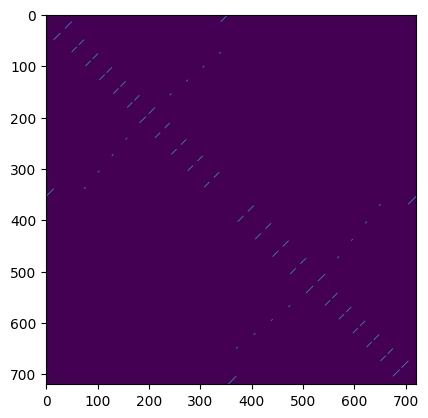

In [6]:
plt.imshow(dot_to_adjacencyv0(df['ss_full'].iloc[0], 720))

In [7]:
def convert(row):
    L = row.L
    bpp_fn = row.sequence_id  # You might need to convert this to Path object if it's not already.
    ss_full = row.ss_full

    extra_bpp = ["vienna_2", "contrafold_2", "rnaformerv1", 'rnafm']
    extra_bpp_path = Path("bpp/R1138v1_m2")
    names = ["vienna_2", "contrafold_2", "rnaformerv1", 'rnafm', 'bpp_org', 'ss_vienna']

    bpp_extra = [
        extra_bpp_from_numpy(extra_bpp_path / f"{i}/{bpp_fn}.npy", L, seq_len=L).numpy()
        for i in extra_bpp
    ]+ [generate_base_pair_matrixv1(f"bpp/R1138v1_m2/organizers/R1138_bpp_files/{bpp_fn}.txt", L).numpy().astype(np.float16)] + [dot_to_adjacencyv0(ss_full, L)]
    
    bpp_extra_d = {s : np.array(d).astype(np.float16) for s, d in zip(names, bpp_extra)}

    # Assuming OUT is a predefined path
    np.savez_compressed(OUT / f"{row.sequence_id}.npz", **bpp_extra_d)

# This function will be used by Pool.map which expects a single-argument function
def worker(index):
    row = df.iloc[index]
    convert(row)
    
with Pool(processes=16) as pool:
    max_ = df.shape[0]
    with tqdm(total=max_) as pbar:
        for _ in pool.imap_unordered(worker, range(max_)):
            pbar.update()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 721/721 [00:20<00:00, 35.04it/s]


In [8]:
!ls bpp/R1138v1_m2/comb

R1138v1.npz	       R1138v1_m2_pos314.npz  R1138v1_m2_pos531.npz
R1138v1_m2_pos0.npz    R1138v1_m2_pos315.npz  R1138v1_m2_pos532.npz
R1138v1_m2_pos1.npz    R1138v1_m2_pos316.npz  R1138v1_m2_pos533.npz
R1138v1_m2_pos10.npz   R1138v1_m2_pos317.npz  R1138v1_m2_pos534.npz
R1138v1_m2_pos100.npz  R1138v1_m2_pos318.npz  R1138v1_m2_pos535.npz
R1138v1_m2_pos101.npz  R1138v1_m2_pos319.npz  R1138v1_m2_pos536.npz
R1138v1_m2_pos102.npz  R1138v1_m2_pos32.npz   R1138v1_m2_pos537.npz
R1138v1_m2_pos103.npz  R1138v1_m2_pos320.npz  R1138v1_m2_pos538.npz
R1138v1_m2_pos104.npz  R1138v1_m2_pos321.npz  R1138v1_m2_pos539.npz
R1138v1_m2_pos105.npz  R1138v1_m2_pos322.npz  R1138v1_m2_pos54.npz
R1138v1_m2_pos106.npz  R1138v1_m2_pos323.npz  R1138v1_m2_pos540.npz
R1138v1_m2_pos107.npz  R1138v1_m2_pos324.npz  R1138v1_m2_pos541.npz
R1138v1_m2_pos108.npz  R1138v1_m2_pos325.npz  R1138v1_m2_pos542.npz
R1138v1_m2_pos109.npz  R1138v1_m2_pos326.npz  R1138v1_m2_pos543.npz
R1138v1_m2_pos11.npz   R1138v1_m2_pos327.npz  R1138v1

In [9]:
np.load('bpp/R1138v1_m2/comb/R1138v1_m2_pos0.npz')

NpzFile 'bpp/R1138v1_m2/comb/R1138v1_m2_pos0.npz' with keys: vienna_2, contrafold_2, rnaformerv1, rnafm, bpp_org...

In [10]:
def get_original_dict(row):
    L = row.L
    bpp_fn = row.sequence_id  # You might need to convert this to Path object if it's not already.
    ss_full = row.ss_full

    extra_bpp = ["vienna_2", "contrafold_2", "rnaformerv1", 'eternafold', 'rnafm']
    extra_bpp_path = Path("bpp/R1138v1_m2")
    names = ["vienna_2", "contrafold_2", "rnaformerv1", 'eternafold', 'rnafm', 'ss_vienna']

    bpp_extra = [
        extra_bpp_from_numpy(extra_bpp_path / f"{i}/{bpp_fn}.npy", L, seq_len=L).numpy()
        for i in extra_bpp
    ]  + [dot_to_adjacencyv0(ss_full, L)]
    
    bpp_extra_d = {s : np.array(d).astype(np.float16) for s, d in zip(names, bpp_extra)}
    return bpp_extra_d

def get_saved(row):
    L = row.L
    bpp_fn = row.sequence_id  # You might need to convert this to Path object if it's not already.
    ss_full = row.ss_full

    extra_bpp = ["vienna_2", "contrafold_2", "rnaformerv", 'eternafold', 'rnafm', 'ss_vienna']
    OUT = Path('bpp/R1138v1_m2/comb')  # replace with your actual output path
    data = np.load(OUT / f"{row.sequence_id}.npz")
    return {i: data[i] for i in extra_bpp}

In [17]:
data = get_original_dict(df.iloc[230])

vienna_2


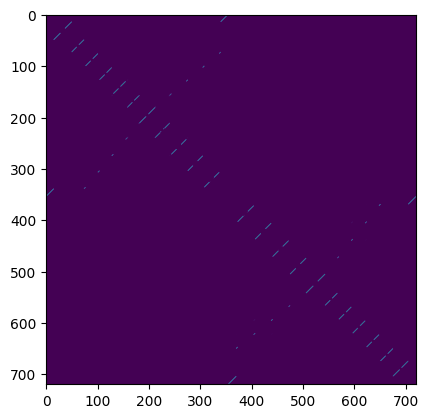

contrafold_2


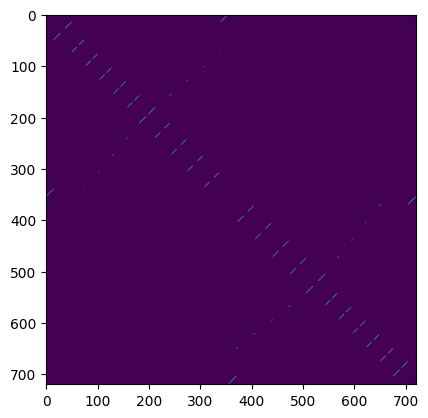

rnaformerv1


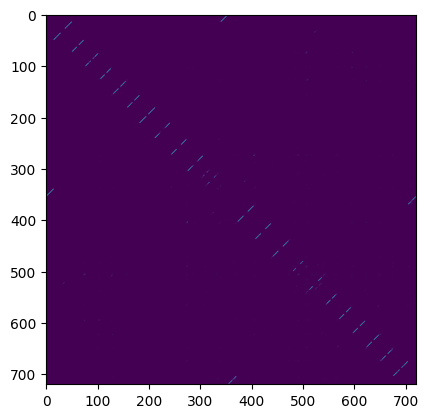

eternafold


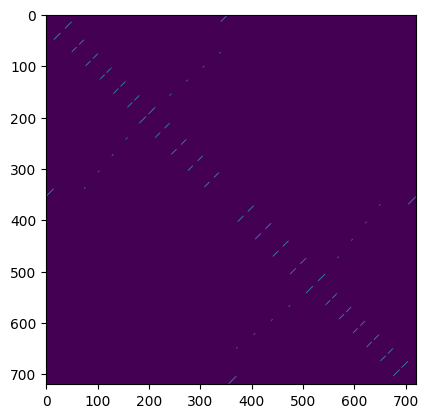

rnafm


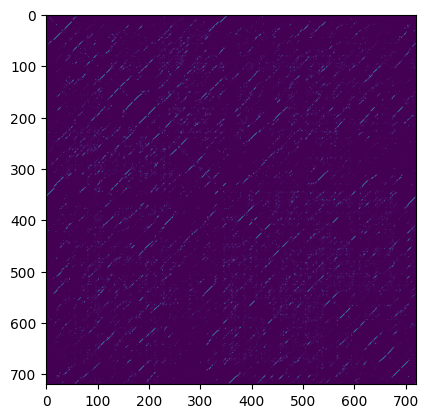

ss_vienna


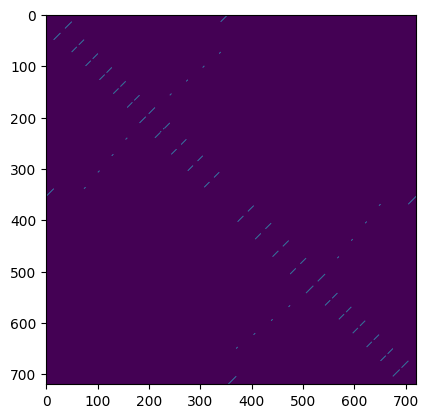

In [18]:
for i in data.keys():
    print(i)
    plt.imshow(data[i])
    plt.pause(0.1)

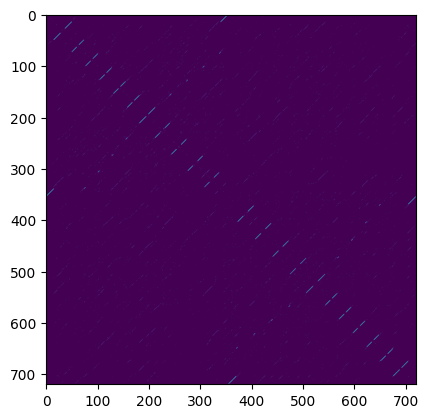

In [20]:
plt.imshow(np.stack([data[i] for i in ['vienna_2', 'contrafold_2', 'rnaformerv1', 'eternafold', 'ss_vienna', 'rnafm']]).mean(0))

In [ ]:
def compare(saved, original):
    assert (np.all([np.allclose(saved[k], original[k]) for k in saved.keys()]))
    
indexs = np.random.choice(np.arange(df.shape[0]), 100)
for index in tqdm(indexs):
    row = df.iloc[index]
    saved = get_saved(row)
    original = get_original_dict(row)
    compare(saved, original)

In [ ]:
np.random.choice